In [5]:
import pandas as pd
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.palettes import Accent6,Blues5,Category20c
import matplotlib.pyplot as plt


output_notebook()

Loading BokehJS ...

In [13]:
data = pd.read_csv('data/jobs.csv',encoding = 'latin1')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Company                     3197 non-null   object
 1   Job Title                   3197 non-null   object
 2   Location                    3197 non-null   object
 3   Job Type                    3197 non-null   object
 4   Experience level            2962 non-null   object
 5   Salary                      3009 non-null   object
 6   Requirment of the company   3198 non-null   object
 7   Facilities                  3198 non-null   object
dtypes: object(8)
memory usage: 200.0+ KB


<h4>Cleanning</h4>

In [14]:
#check duplicated
data.duplicated().sum()

202

In [15]:
#remove duplicated
data.drop_duplicates(inplace=True)

In [16]:
#check null in data
data.isna().sum()

Company                         1
Job Title                       1
Location                        1
Job Type                        1
Experience level              228
Salary                        172
Requirment of the company       0
Facilities                      0
dtype: int64

In [17]:
#Drop rows null
data.drop(index=data.loc[data['Company'].isna()].index,inplace=True)

In [18]:
#Replace data null of Experience column with 'No experience'
data['Experience level'].fillna('No specific',inplace=True)

In [19]:
#Replace data null of Salary column with 'No salary'
data['Salary'].fillna('0',inplace=True)

In [20]:
import re

def cleanSalary(salary):
    currency_paterns = re.compile("["
                                  u"GBP"
                                  u"EUR"
                                  u"+"
                                  u"K"
                                  u"*"
                                  "]+",flags=re.UNICODE)

    return int(currency_paterns.sub(r'',salary))*1000
 
data['Salary'] = data['Salary'].apply(lambda x:cleanSalary(x))

In [21]:
#Drop Salary equal zero where Experience level defferent Entership
indexs = data.loc[(data['Salary'] == 0) & (data['Job Type'] != 'Internship')].index

data.drop(index=indexs,inplace=True)

In [22]:
#!pip install pycountry
import pycountry

In [23]:
def getCountryFromLocation(txt):
    for country in pycountry.countries:
        if country.name in txt or country.alpha_3 in txt:
            ctry = country.name
            break
        else:
            ctry = 'Not found'#txt
    return ctry


data['country'] = data['Location'].apply(lambda x:getCountryFromLocation(x))

In [24]:

#BI, Big Data, Data Analyst, Data Analysis, Data Sience, Data Scientist, Data Engineer, Data Engineering
def getSubTitleJob(t):
    if ('Data Engineer'.upper() in t.upper()) | ('Data Engineering'.upper() in t.upper()):
        return 'Data Engineer'.title()
    elif ('BI'.upper() in t.upper()) | ('Business Intelligence'.upper() in t.upper()):
        return 'Business Intelligence'.title()
    elif ('Big Data'.upper() in t.upper()):
        return 'Big Data'.title()
    elif ('Data Analyst'.upper() in t.upper()) | ('Data Analysis'.upper() in t.upper()) | ('Data Analytics'.upper() in t.upper()):
        return 'Data Analyst'.title()
    elif ('Data Science'.upper() in t.upper()) | ('Data Scientist'.upper() in t.upper()):
        return 'Data Science'.title()
    elif ('Machine Learning'.upper() in t.upper()) | ('ML'.upper() in t.upper()):
        return 'Machine Learning'.title()
    elif ('AI'.upper() in t.upper()) | ('Artificial Intelligence'.upper() in t.upper()):
        return 'Artificial Intelligence'
    else:
        return t

data['New Job Title'] = data['Job Title'].apply(lambda x:getSubTitleJob(x))

In [25]:
#Export data cleaned to csv
data.to_csv('data/cleaned_jobs.csv')

<h4>Analyse and visualization</h4>

In [6]:
data = pd.read_csv('data/cleaned_jobs.csv',index_col=0)

In [27]:
#Opportunities by country
d = data.loc[data['country'] != 'Not found'].groupby('country')['country'].count().sort_values(ascending=False).head(10).reset_index(name='counts').sort_values(by='counts',ascending=True)

#create bars
p = figure(y_range=d['country'],x_range=(0,max(d['counts'])),title=f'',tools='hover',tooltips='Opportunités : @counts')
p.hbar(y='country',right='counts',height=0.90,source=d)
show(p)

In [28]:
#Opportunities by companies
d = data.groupby('Company')['Company'].count().sort_values(ascending=False).reset_index(name='counts').head(50)
#create bars
p = figure(x_range=d['Company'],y_range=(0,max(d['counts'])),title=f'',tools='hover',tooltips='Company : @Company - Opportunités : @counts')
p.vbar(x='Company',top='counts',width=0.90,source=d)

p.xaxis.major_label_orientation = 4/-3

show(p)

In [29]:
#Job title more required
d = data.groupby('New Job Title')['New Job Title'].count().sort_values(ascending=False).reset_index(name='counts').rename(columns={'New Job Title':'Job_Title'}).head(10)

p = figure(x_range=d['Job_Title'],y_range=(0,max(d['counts'])),title=f'',tools='hover',tooltips='Job Title : @Job_Title - Opportunités : @counts')
p.vbar(x='Job_Title',top='counts',width=0.90,source=d)

p.xaxis.major_label_orientation = 4/-3

show(p)

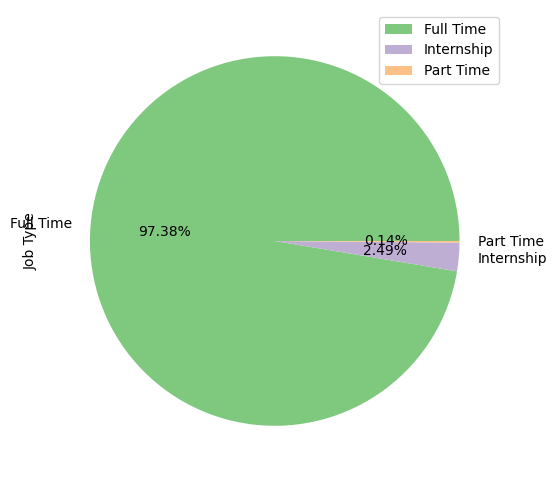

In [30]:

#Counts of opportunities by Jop Typs
d = data.groupby(by='Job Type')['Job Type'].count()

dd = pd.DataFrame(d,index=['Full Time','Internship','Part Time'])

dd.plot.pie(y='Job Type',autopct="%.2f%%", colors=Accent6,figsize=(6, 6))

plt.show()

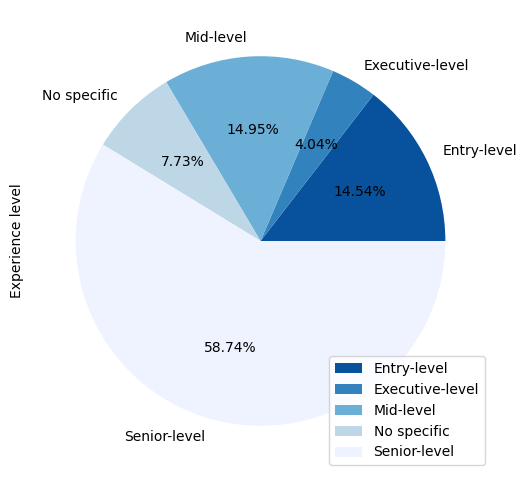

In [31]:
#Counts of opportunities by experience level
d = data.groupby('Experience level')['Experience level'].count()

dd = pd.DataFrame(d,index=['Entry-level','Executive-level','Mid-level','No specific','Senior-level'])

dd.plot.pie(y='Experience level',autopct="%.2f%%", colors=Blues5,figsize=(6, 6))

plt.show()

In [32]:
#Top salary by job title
jobTitle = data.groupby('New Job Title')['Salary'].mean().sort_values(ascending=False).head(50).reset_index(name='AVG').head(40).rename(columns={'New Job Title':'Job_Title'})
#data.groupby('Job Title')['Job Title'].count().sort_values(ascending=False).head(10)

p = figure(x_range=jobTitle['Job_Title'],y_range=(0,max(jobTitle['AVG'])),title=f'Salaire le plus élevé par titre de poste',tools='hover',tooltips='Job Title : @Job_Title - AVG Salary : @AVG USD')
p.vbar(x='Job_Title',top='AVG',width=0.90,source=jobTitle)

p.xaxis.major_label_orientation = 3/-3

show(p)

In [3]:
#Requirment of the company
requirments = []
for index,row in data.iterrows():
    requirments.extend(row['Requirment of the company '].split(','))

requirments = pd.DataFrame(requirments)

indexs = requirments.loc[requirments[0] == ''].index

requirments.drop(index=indexs,inplace=True)


dr = requirments.groupby([0])[0].count().sort_values(ascending=False).head(20)

data_dr = dr.reset_index(name='counts')

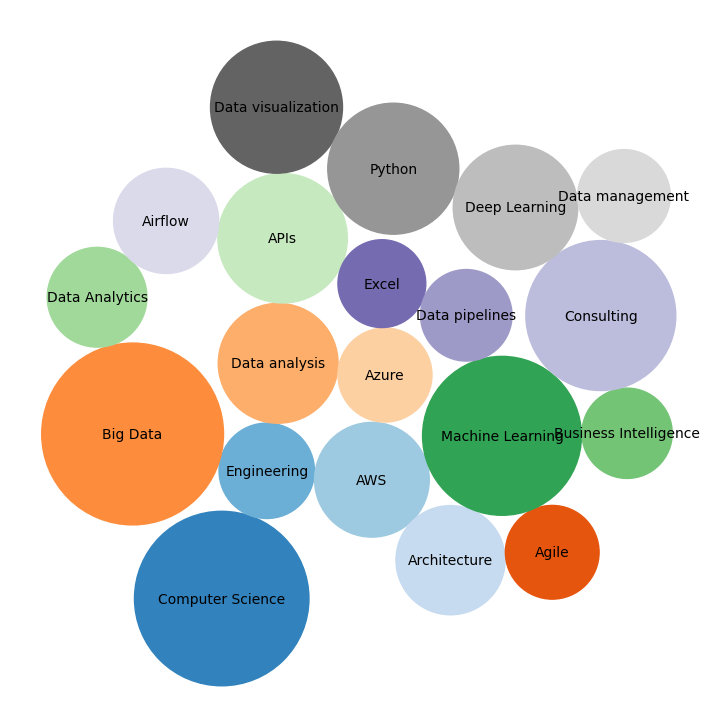

In [4]:
from bubble_chart import BubbleChart

#random data
data_dr_r = data_dr.sample(frac=1)

bubble_chart = BubbleChart(area=data_dr_r['counts'],
                           bubble_spacing=0.1)
bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
fig.set_size_inches(9, 13, forward=True)
bubble_chart.plot(
    ax, data_dr_r[0],Category20c[20])
ax.axis("off")
ax.relim()
ax.autoscale_view()
plt.show()

<h1>L'insertion de données dans la base de données</h1>

In [7]:
import pyodbc

cnx = pyodbc.connect('Driver={SQL Server};'
                      'Server=LAPTOP-B5O30HDH\SQLEXPRESS;'
                      'Database=oppodb;'
                      'Trusted_Connection=yes;')

In [8]:
dataToInsert = data
dataToInsert.head()

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,country,New Job Title
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48000,"Computer Science,Data quality,Genetics,Mathema...",",,,,",United States,Data Analyst
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48000,"Agile,Data management,Finance,Security,,",",,,,",Mauritius,Data Analyst
2,Cricut,Machine Learning Engineer,"South Jordan, UT, United States",Full Time,No specific,90000,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,",Jordan,Machine Learning
3,Bosch Group,Application Developer & Data Analyst,"Nonantola, Italy",Full Time,Entry-level,48000,"Engineering,Industrial,Oracle,Power BI,R,R&D",",,,,",Italy,Data Analyst
4,Publicis Groupe,Data Engineer Full time (Public Sector) USA,"Arlington, VA, United States",Full Time,Mid-level,108000,"AWS,Azure,Computer Science,Consulting,Dataflow...","Flex hours,Flex vacation,Parental leave,Unlimi...",United States,Data Engineer


<h3>Countries</h3>


In [9]:
countries = []
for index,row in pd.DataFrame(dataToInsert['country'].unique()).rename(columns={0:'name'}).iterrows():
    countries.append(dict(countryID=index+1,name=row['name']))

countries = pd.DataFrame(countries)
countries

,countryID,name
0,1,United States
1,2,Mauritius
2,3,Jordan
3,4,Italy
4,5,Portugal
...,...,...
74,75,Albania
75,76,Peru
76,77,Bangladesh
77,78,Lebanon


In [10]:
#Replace country with id
for index,c in countries.iterrows():
    dataToInsert['country'].replace(c['name'],c['countryID'],inplace=True)

In [11]:
#Insert countries into database

cursor = cnx.cursor()
for index,c in countries.iterrows():
    cursor.execute('INSERT INTO countries VALUES(?,?)',c['countryID'],c['name'])
cursor.commit()
cursor.close()

<h3>Experience Level</h3>

In [12]:
experienceLevel = []

for index,row in pd.DataFrame(dataToInsert['Experience level'].unique()).rename(columns={0:'name'}).iterrows():
    experienceLevel.append(dict(levelID=index+1,name=row['name']))

experienceLevel = pd.DataFrame(experienceLevel)
experienceLevel

,levelID,name
0,1,Entry-level
1,2,No specific
2,3,Mid-level
3,4,Senior-level
4,5,Executive-level


In [13]:
#Replace experience level
for index,e in experienceLevel.iterrows():
    dataToInsert['Experience level'].replace(e['name'],e['levelID'],inplace=True)

In [14]:
#Insert experience level into database
cursor = cnx.cursor()
for index,ex in experienceLevel.iterrows():
    cursor.execute('INSERT INTO experienceLevels VALUES (?,?)',ex['levelID'],ex['name'])
cursor.commit()
cursor.close()

<h3>Companies</h3>

In [15]:
companies = []

for index,row in pd.DataFrame(dataToInsert['Company'].unique()).rename(columns={0:'name'}).iterrows():
    companies.append(dict(companyID=index+1,name=row['name']))

companies = pd.DataFrame(companies)
companies

,companyID,name
0,1,SGS
1,2,Ocorian
2,3,Cricut
3,4,Bosch Group
4,5,Publicis Groupe
...,...,...
1070,1071,Junglee Games
1071,1072,Thaloz
1072,1073,Rackspace
1073,1074,MUFG Investor Services


In [16]:
#Replace company names by id
for index,c in companies.iterrows():
    dataToInsert['Company'].replace(c['name'],c['companyID'],inplace=True)

In [17]:
#insert companies into database

cursor = cnx.cursor()
for index,c in companies.iterrows():
    cursor.execute('INSERT INTO companies values (?,?)',c['companyID'],c['name'])
cursor.commit()
cursor.close()

<h3>Job Type<h3>

In [18]:
jobType = []

for index,row in pd.DataFrame(dataToInsert['Job Type'].unique()).rename(columns={0:'name'}).iterrows():
    jobType.append(dict(typeID=index+1,name=row['name']))

jobType = pd.DataFrame(jobType)
jobType

,typeID,name
0,1,Full Time
1,2,Internship
2,3,Part Time


In [19]:
#replace job type by id

for index,jtype in jobType.iterrows():
    dataToInsert['Job Type'].replace(jtype['name'],jtype['typeID'],inplace=True)

In [20]:
#Insert job type into database

cursor = cnx.cursor()
for index,tp in jobType.iterrows():
    cursor.execute('INSERT INTO jobTypes VALUES(?,?)',tp['typeID'],tp['name'])
cursor.commit()
cursor.close()

<h3>Jobs</h3>

In [15]:
dataToInsert.head(3)

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities,country,New Job Title
0,1,Clinical Data Analyst,"Richardson, TX, United States",1,1,48000,"Computer Science,Data quality,Genetics,Mathema...",",,,,",1,Data Analyst
1,2,AML/CFT & Data Analyst,"Ebène, Mauritius",1,1,48000,"Agile,Data management,Finance,Security,,",",,,,",2,Data Analyst
2,3,Machine Learning Engineer,"South Jordan, UT, United States",1,2,90000,"Agile,Architecture,AWS,Computer Science,Comput...","Career development,,,,",3,Machine Learning


In [21]:

#insert jobs into database -- ,,jobLocation,salary,companyID,levelID,countryID,typeID
#,str(),str(),str(),str()

cursor = cnx.cursor()
for index,job in dataToInsert.iterrows():
    index=index+1
    cursor.execute('INSERT INTO jobs(jobID,jobName,jobLocation,salary,companyID,levelID,countryID,typeID) VALUES(?,?,?,?,?,?,?,?)',index,job['New Job Title'],job['Location'],job['Salary'],job['Company'],job['Experience level'],job['country'],job['Job Type'])
cursor.commit()
cursor.close()

<h3>Requirments<h3>

In [22]:
requirments = []

for index,rec in dataToInsert[['Company','Requirment of the company ']].iterrows():
    for r in rec['Requirment of the company '].split(','):
        if r != '':
            requirments.append(dict(jobID=rec['Company'],name=r))

requirments = pd.DataFrame(requirments)
requirments.drop_duplicates(inplace=True)
requirments

,jobID,name
0,1,Computer Science
1,1,Data quality
2,1,Genetics
3,1,Mathematics
4,1,SAS
...,...,...
16637,9,Docker
16639,673,Data Analytics
16640,673,Data Mining
16641,673,Economics


In [23]:
#Insert requirments into database

cursor = cnx.cursor()

for index,r in requirments.iterrows():
    cursor.execute('INSERT INTO requirments VALUES (?,?)',r['jobID'],r['name'])

cursor.commit()
cursor.close()

 <h3>Facilities</h3>

In [24]:
facilities = []

for index,f in dataToInsert[['Company','Facilities']].iterrows():
    for r in f['Facilities'].split(','):
        if r != '':
            facilities.append(dict(jobID=f['Company'],name=r))

facilities = pd.DataFrame(facilities)
facilities.drop_duplicates(inplace=True)
facilities

,jobID,name
0,3,Career development
1,5,Flex hours
2,5,Flex vacation
3,5,Parental leave
4,5,Unlimited paid time off
...,...,...
8212,1075,Flex hours
8213,1075,Health care
8214,1075,Insurance
8234,624,Equity


In [25]:
#Insert facilities into database

cursor = cnx.cursor()

for index,f in facilities.iterrows():
    cursor.execute('INSERT INTO facilities VALUES (?,?)',f['jobID'],f['name'])

cursor.commit()
cursor.close()